In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

from keras.models import load_model,model_from_json


# load json and create model
json_file = open('/content/drive/MyDrive/faultSeg-master/faultSeg-master/model/model3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/faultSeg-master/faultSeg-master/model/pretrained_model.hdf5")
print("Loaded model from disk")

# training image dimensions
n1, n2, n3 = 128, 128, 128

Loaded model from disk


1/1 [==============================] - 1s 921ms/step


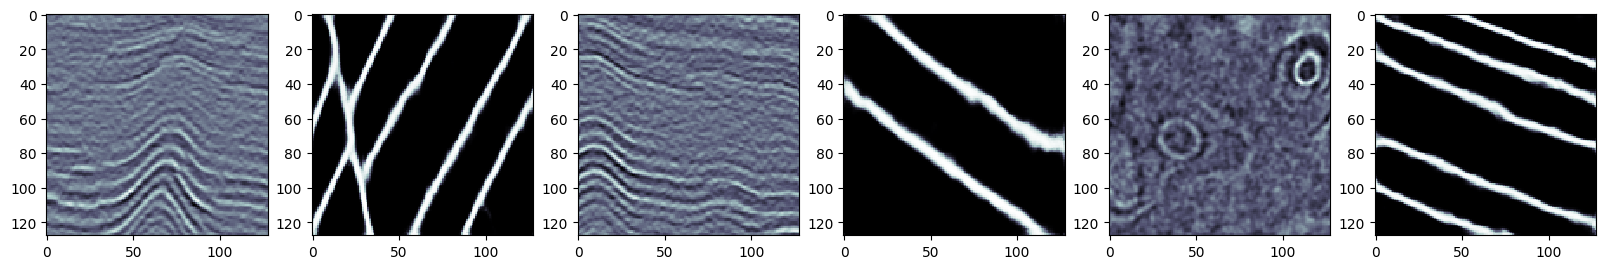

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

gx,m1,m2,m3 = np.fromfile("/content/drive/MyDrive/faultSeg-master/faultSeg-master/data/train/seis/8.dat",dtype=np.single),128,128,128
gx = gx-np.min(gx)
gx = gx/np.max(gx)
gx = gx*255
k = 50
x = np.reshape(gx,(1,n1,n2,n3,1))
Y = loaded_model.predict(x,verbose=1)
fig = plt.figure(figsize=(20,20))
#inline slice
k1 = 50
plt.subplot(1, 6, 1)
imgplot1 = plt.imshow(np.transpose(x[0,k,:,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 2)
imgplot2 = plt.imshow(np.transpose(Y[0,k,:,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)


#xline slice
k2 = 110
plt.subplot(1, 6, 3)
imgplot1 = plt.imshow(np.transpose(x[0,:,k2,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 4)
imgplot2 = plt.imshow(np.transpose(Y[0,:,k2,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)



#time slice
k3 = 60
plt.subplot(1, 6, 5)
imgplot1 = plt.imshow(np.transpose(x[0,:,:,k3,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 6)
imgplot2 = plt.imshow(np.transpose(Y[0,:,:,k3,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)



1/1 [==============================] - 1s 649ms/step


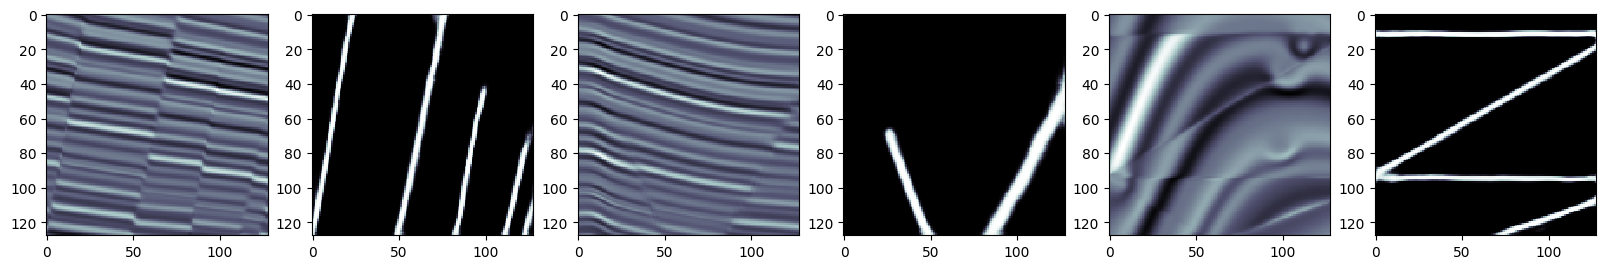

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

gx,m1,m2,m3 = np.fromfile("/content/drive/MyDrive/faultSeg-master/faultSeg-master/data/validation/seis/8.dat",dtype=np.single),128,128,128
gx = gx-np.min(gx)
gx = gx/np.max(gx)
gx = gx*255
k = 50
x = np.reshape(gx,(1,n1,n2,n3,1))
Y = loaded_model.predict(x,verbose=1)
fig = plt.figure(figsize=(20,20))
#inline slice
k1 = 50
plt.subplot(1, 6, 1)
imgplot1 = plt.imshow(np.transpose(x[0,k,:,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 2)
imgplot2 = plt.imshow(np.transpose(Y[0,k,:,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)



#xline slice
k2 = 110
plt.subplot(1, 6, 3)
imgplot1 = plt.imshow(np.transpose(x[0,:,k2,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 4)
imgplot2 = plt.imshow(np.transpose(Y[0,:,k2,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)


#time slice
k3 = 60
plt.subplot(1, 6, 5)
imgplot1 = plt.imshow(np.transpose(x[0,:,:,k3,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 6)
imgplot2 = plt.imshow(np.transpose(Y[0,:,:,k3,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)


In [5]:
def getMask(os):
    sc = np.zeros((n1,n2,n3),dtype=np.single)
    sc = sc+1
    sp = np.zeros((os),dtype=np.single)
    sig = os/4
    sig = 0.5/(sig*sig)
    for ks in range(os):
        ds = ks-os+1
        sp[ks] = np.exp(-ds*ds*sig)
    for k1 in range(os):
        for k2 in range(n2):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k1]
                sc[n1-k1-1][k2][k3]=sp[k1]
    for k1 in range(n1):
        for k2 in range(os):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k2]
                sc[k1][n3-k2-1][k3]=sp[k2]
    for k1 in range(n1):
        for k2 in range(n2):
            for k3 in range(os):
                sc[k1][k2][k3]=sp[k3]
                sc[k1][k2][n3-k3-1]=sp[k3]
    return sc

In [6]:
def predictWithMask(gx):
  os = 12 #overlap width
  c1 = np.round((m1+os)/(n1-os)+0.5)
  c2 = np.round((m2+os)/(n2-os)+0.5)
  c3 = np.round((m3+os)/(n3-os)+0.5)
  c1 = int(c1)
  c2 = int(c2)
  c3 = int(c3)
  p1 = (n1-os)*c1+os
  p2 = (n2-os)*c2+os
  p3 = (n3-os)*c3+os
  gx = np.reshape(gx,(m1,m2,m3))
  gp = np.zeros((p1,p2,p3),dtype=np.single)
  gy = np.zeros((p1,p2,p3),dtype=np.single)
  mk = np.zeros((p1,p2,p3),dtype=np.single)
  gs = np.zeros((1,n1,n2,n3,1),dtype=np.single)
  gp[0:m1,0:m2,0:m3]=gx
  sc = getMask(os)
  for k1 in range(c1):
      for k2 in range(c2):
          for k3 in range(c3):
              b1 = k1*n1-k1*os
              e1 = b1+n1
              b2 = k2*n2-k2*os
              e2 = b2+n2
              b3 = k3*n3-k3*os
              e3 = b3+n3
              gs[0,:,:,:,0]=gp[b1:e1,b2:e2,b3:e3]
              gs = gs-np.min(gs)
              gs = gs/np.max(gs)
              gs = gs*255
              Y = loaded_model.predict(gs,verbose=1)
              Y = np.array(Y)
              gy[b1:e1,b2:e2,b3:e3]= gy[b1:e1,b2:e2,b3:e3]+Y[0,:,:,:,0]*sc
              mk[b1:e1,b2:e2,b3:e3]= mk[b1:e1,b2:e2,b3:e3]+sc
  gy = gy/mk
  gy = gy[0:m1,0:m2,0:m3]
  return gx,gy
  # gy.tofile("/content/drive/MyDrive/faultSeg-master/faultSeg-master/data/prediction/f3d/"+"fp.dat",format="%4")



In [10]:

import matplotlib.pyplot as plt
import segyio
import numpy as np
%matplotlib inline

def stdMin(gx):
    gm = np.mean(gx)
    gs = np.std(gx)
    gx = gx - gm
    gx = gx / gs
    return gx

seismPath = "/content/drive/MyDrive/faultSeg-master/faultSeg-master/South Deep_3D/GFI_South_Deeps_3D"
gx = segyio.tools.cube(seismPath)
print(gx.shape)
gx = gx[:, :, :512]
m1, m2, m3 = gx.shape
gx = stdMin(gx)
print(gx.shape)
gx, gy = predictWithMask(gx)


(714, 600, 3001)
(714, 600, 512)
1/1 [==============================] - 1s 675ms/step


<ipython-input-6-713f8613bfce>:30: RuntimeWarning: invalid value encountered in divide
  gs = gs/np.max(gs)


1/1 [==============================] - 1s 651ms/step


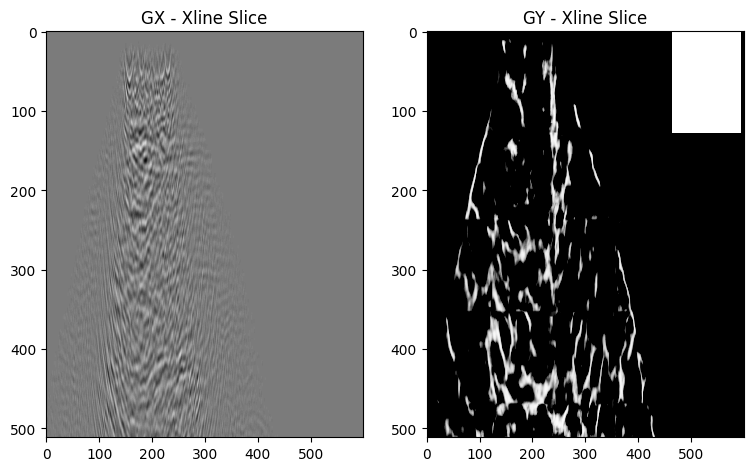

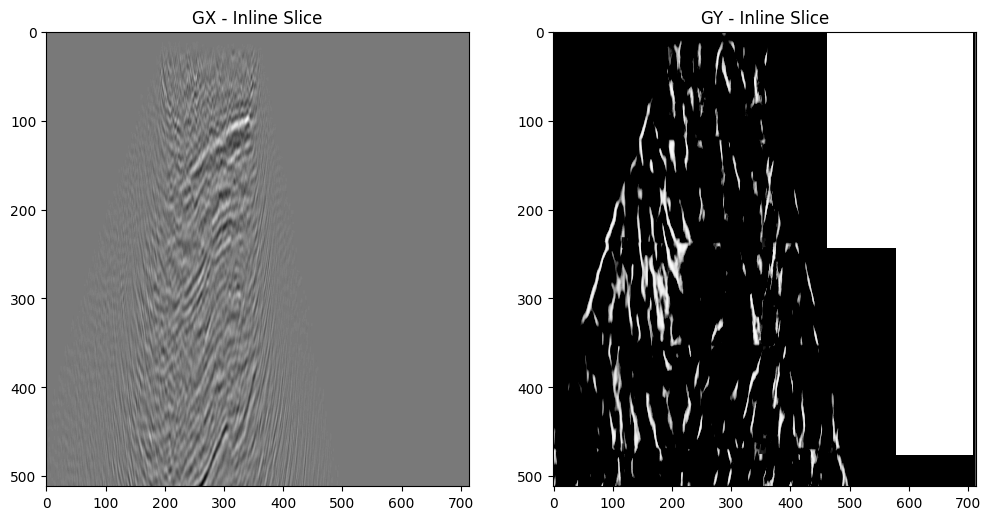

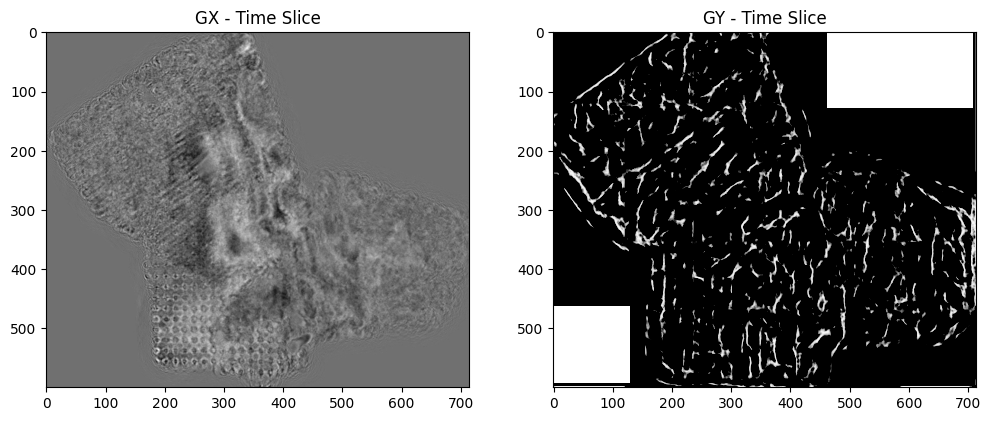

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from PIL import Image

# Load data - specify your file path and ensure it's correctly shaped
# For example:
# gx, m1, m2, m3 = np.fromfile("path/to/file", dtype=np.single), 560, 773, 512
# gy, m1, m2, m3 = np.fromfile("path/to/file", dtype=np.single), 560, 773, 512

# Reshape loaded data arrays
gx = np.reshape(gx, (m1, m2, m3))
gy = np.reshape(gy, (m1, m2, m3))

# Indices for slicing (adjust these values as needed)
k1, k2, k3 = 29, 29, 99

# Extracting slices and transposing for visualization
gx1, gy1 = np.transpose(gx[k1, :, :]), np.transpose(gy[k1, :, :])
gx2, gy2 = np.transpose(gx[:, k2, :]), np.transpose(gy[:, k2, :])
gx3, gy3 = np.transpose(gx[:, :, k3]), np.transpose(gy[:, :, k3])

# Plot and save xline slice
fig = plt.figure(figsize=(9, 9))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx1, aspect=1.5, cmap=plt.cm.gray)
p1.set_title("GX - Xline Slice")
p2 = plt.subplot(1, 2, 2)
p2.imshow(gy1, aspect=1.5, interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
p2.set_title("GY - Xline Slice")
plt.savefig("xline_slice.png")

# Plot and save inline slice
fig = plt.figure(figsize=(12, 12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx2, aspect=1.5, cmap=plt.cm.gray)
p1.set_title("GX - Inline Slice")
p2 = plt.subplot(1, 2, 2)
p2.imshow(gy2, aspect=1.5, interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
p2.set_title("GY - Inline Slice")
plt.savefig("inline_slice.png")

# Plot and save time slice
fig = plt.figure(figsize=(12, 12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx3, cmap=plt.cm.gray)
p1.set_title("GX - Time Slice")
p2 = plt.subplot(1, 2, 2)
p2.imshow(gy3, interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
p2.set_title("GY - Time Slice")
plt.savefig("time_slice.png")

plt.show()


In [ ]:
!pip install segyio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 2.1 MB/s eta 0:00:00


In [9]:
!pip install segyio



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
!pip install numpy as

In [5]:
!python /content/drive/MyDrive/faultSeg-master/faultSeg-master/train_model_final.py

2024-11-11 17:21:50.579078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 17:21:50.598900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 17:21:50.604773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 17:21:51.598956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1731345713.293821    4378 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b